# Traveling Salesman Problem

Solved using Pyomo

In [1]:
# import necessary packages
import time
import numpy as np
import numpy.random as random

import dimod
import networkx as nx

from pyomo.environ import *
from pyomo.opt import SolverFactory

{(0, 1): Text(0.9990133616401945, 0.03139525253964962, '1'),
 (0, 2): Text(0.9960573587116088, 0.06266660939532046, '1'),
 (0, 3): Text(0.9911436114376782, 0.09369064795521428, '2'),
 (0, 4): Text(0.9842915807347763, 0.1243449440051673, '5'),
 (0, 5): Text(0.9755282675067849, 0.15450849266660882, '7'),
 (0, 6): Text(0.9648882424474154, 0.18406226346481158, '6'),
 (0, 7): Text(0.9524135268309206, 0.2128896324625632, '7'),
 (0, 8): Text(0.9381533242911948, 0.24087684419615965, '7'),
 (0, 9): Text(0.9221639612171302, 0.2679133916550129, '6'),
 (0, 10): Text(0.9045084993224278, 0.2938926123280941, '3'),
 (0, 11): Text(0.8852566164363098, 0.3187119862271556, '8'),
 (0, 12): Text(0.8644843084802969, 0.3422735531192407, '5'),
 (0, 13): Text(0.8422735616426653, 0.3644842999568723, '4'),
 (0, 14): Text(0.8187119947505801, 0.3852566079128852, '7'),
 (0, 15): Text(0.7938926208515187, 0.40450849079900325, '5'),
 (0, 16): Text(0.7679133703761153, 0.4221639824960277, '2'),
 (0, 17): Text(0.740876852

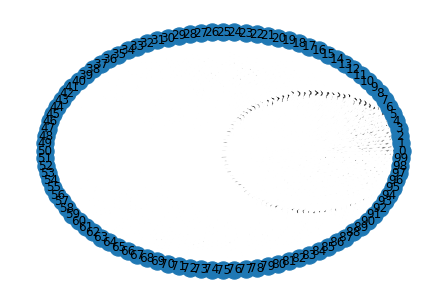

In [90]:
# generate random graph
# number of nodes
num_nodes = 100
# edge generation probability
p = 1
# seed (optional)
seed = 50
random.seed(seed)
#generate graph
graph = nx.gnp_random_graph(num_nodes,p,seed)

for (u, v) in graph.edges():
    graph.edges[u,v]['weight'] = random.randint(1,10)
    
    
# draw graph
pos = nx.circular_layout(graph)
nx.draw(graph, pos=pos, with_labels=True)
labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=labels)

## Build problem model

In [72]:
# instantiate
model = ConcreteModel()

# define variables ----------------------------------
# binary variables
model.x = VarList(domain=Binary, bounds=(0,1))
# dictionary to assign node/color pairing to certain variable
var_dict = {}
indx = 1
for i,j in graph.edges:
    model.x.add()
    var_dict[(i,j)] = model.x[indx]
    indx += 1
    model.x.add()
    var_dict[(j,i)] = model.x[indx]
    indx += 1

# dummy variables for one-tour constraint
model.u = Var([i for i in range(1,num_nodes+1)], domain=Integers, bounds=(1,num_nodes-1))

# set objective --------------------------------
obj = 0
for i,j in graph.edges:
    obj += graph[i][j]['weight']*var_dict[(i,j)] + graph[j][i]['weight']*var_dict[(j,i)]
model.OBJ = Objective(expr = obj, sense=minimize)

# add constraints --------------------------------
# one incoming path per node
model.one_inc = ConstraintList()
for j in graph.nodes:
    edge_sum = 0
    for i in graph.nodes:
        if (i,j) in graph.edges:
            edge_sum += var_dict[(i,j)]
    model.one_inc.add(edge_sum == 1)
    
# one outgoing path per node
model.one_out = ConstraintList()
for i in graph.nodes:
    edge_sum = 0
    for j in graph.nodes:
        if (i,j) in graph.edges:
            edge_sum += var_dict[(i,j)]
    model.one_out.add(expr = edge_sum == 1)
    
# one tour
model.one_tour = ConstraintList()
for i,j in graph.edges:
    if (i,j)>(1,1) and i<num_nodes and j<num_nodes:
        model.one_tour.add(expr = model.u[i]-model.u[j]+(num_nodes-1)*var_dict[(i,j)] <= num_nodes-2)
        model.one_tour.add(expr = model.u[j]-model.u[i]+(num_nodes-1)*var_dict[(j,i)] <= num_nodes-2)
        
model.pprint()

5 Set Declarations
    one_inc_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   20 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
    one_out_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   20 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
    one_tour_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :  342 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 1

## Solve

In [73]:
instance = model.create_instance()
opt = SolverFactory('glpk')

results = opt.solve(model)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 25.0
  Upper bound: 25.0
  Number of objectives: 1
  Number of constraints: 383
  Number of variables: 400
  Number of nonzeros: 1787
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 513
      Number of created subproblems: 513
  Error rc: 0
  Time: 0.3611116409301758
# ----------------------------------------------------------
#   Solution Information
# -----------------------------

In [74]:
model.OBJ.display()

OBJ : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True :  25.0


{(0, 1): Text(0.9755282586094334, 0.15450851254631864, '1'),
 (0, 2): Text(0.9045084908399321, 0.2938926313936037, '1'),
 (0, 3): Text(0.793892613015176, 0.4045085092183598, '2'),
 (0, 4): Text(0.65450847926673, 0.4755282769878611, '5'),
 (0, 5): Text(0.49999997307771377, 0.5000000066559177, '7'),
 (0, 6): Text(0.3454914807977634, 0.47552824718553915, '6'),
 (0, 7): Text(0.20610737685163927, 0.4045085092183598, '7'),
 (0, 8): Text(0.0954914990268832, 0.2938926313936037, '7'),
 (0, 9): Text(0.02447176105970389, 0.15450852744747964, '6'),
 (0, 10): Text(1.5893253380028227e-09, -3.0399552337081695e-08, '3'),
 (0, 11): Text(0.02447173125738189, -0.15450847102148693, '8'),
 (0, 12): Text(0.0954915288292052, -0.29389263457225495, '5'),
 (0, 13): Text(0.20610746625860527, -0.404508542199333, '4'),
 (0, 14): Text(0.34549143609428035, -0.4755282205618684, '7'),
 (0, 15): Text(0.5000000008958478, -0.49999998003224694, '5'),
 (0, 16): Text(0.6545085537725349, -0.4755282205618684, '2'),
 (0, 17): 

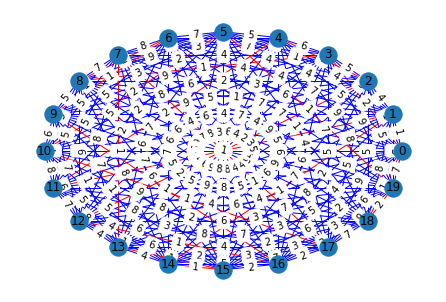

In [75]:
for (i,j) in var_dict:
    if (i,j) in graph.edges:
        graph[i][j]['color'] = 'blue'
    if var_dict[(i,j)].value > 0.5 or var_dict[(j,i)].value > 0.5:
        graph[i][j]['color'] = 'red'
        
edges = graph.edges()
colors = [graph[u][v]['color'] for u,v in edges]
weights = [graph[u][v]['weight'] for u,v in edges]

# draw
nx.draw(graph, pos, edge_color=colors, with_labels=True)
labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=labels)

In [91]:
p = nx.approximation.greedy_tsp(graph)
print(p)

[0, 1, 4, 6, 12, 15, 13, 2, 8, 31, 18, 35, 9, 20, 3, 16, 19, 26, 7, 24, 11, 23, 21, 38, 45, 49, 34, 25, 30, 27, 17, 10, 29, 32, 33, 80, 44, 41, 39, 5, 28, 36, 69, 43, 42, 51, 59, 48, 46, 37, 22, 47, 62, 89, 81, 75, 61, 55, 82, 64, 68, 40, 95, 57, 52, 14, 88, 54, 58, 74, 93, 70, 53, 96, 56, 60, 77, 66, 71, 78, 86, 85, 97, 72, 67, 92, 84, 50, 63, 91, 87, 94, 83, 79, 90, 73, 76, 99, 65, 98, 0]


In [92]:
print(len(p))
print(max(p))
dist = 0
for i in range(len(p)-1):
    dist += graph[p[i]][p[i+1]]['weight']
    
print(dist)

101
99
111
